## Import libraries and relavant functions

In [1]:
import sys, os
sys.stderr = open(os.devnull, 'w')

import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai

# run_clean = "quad_clean_config"
# run_adv = "quad_adv_config"
run = "run-20251107-173544"
# run_adv="trial_quad_config_0.2_100"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## Load our pretrained model on OG dataset and further on a mix of adversarial+clean dataset (p=0.5)

In [4]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model_name = cfg["model"]["name"]
    model = make_model(model_name,
                       in_dim=cfg["model"][model_name]["in_dim"],
                       hidden=tuple(cfg["model"][model_name]["hidden"]),
                       out_dim=cfg["model"][model_name]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'pendulum', 'dynamics': {'params': {'m': 2.0, 'l': 1.0, 'c': 0.0, 'g': 9.81}, 'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4'}, 'controller': {'type': 'pid', 'pid': {'theta': {'Kp': 10.0, 'Ki': 0.0, 'Kd': 10.0, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 0.0}}}, 'data': {'n_trajectories': 50, 'sim_time': 5, 'train_ratio': 0.8, 'val_ratio': 0.1, 'test_ratio': 0.1, 'standardize': True}, 'model': {'name': 'mlp', 'mlp': {'hidden': [32, 32], 'dropout': 0.0, 'in_dim': 3, 'out_dim': 1}}, 'train': {'batch_size': 16, 'epochs': 100, 'lr': '1e-4', 'show_val_progress': True, 'show_test_progress': False, 'adv': {'enabled': False, 'method': 'pgd', 'norm': 'linf', 'eps': 0.1, 'steps': 40, 'alpha': None, 'p': 1.0, 'mode': 'mix', 'mix_alpha': 0.5, 'start_epoch': 0, 'save_samples': 16, 'save_every': 1, 'clip': {'enabled': False, 'lo': [-3.1416, -10.0], 'hi': [3.1416, 10.0]}}}, 'verify': {'attack': 'pgd', 'norm': 'linf', 'eps': 0.03, 'steps': 40, 'alpha': None, 

# **Lipschitz Robustness Analysis**

\begin{equation}
    |\mathcal{F}(x) - \mathcal{F}(\hat x)| \leq L \cdot ||x - \hat x||
\end{equation}

A model is Lipschitz continuous if there exists a constant $L$ such that for all inputs $x$ and $\hat x$, the change in the model's output is bounded by $L$ times the change in the input.

Where:
- **Smaller $L$** values indicate that the **model's output changes slowly** with input changes, suggesting robustness to small perturbations.
- **Larger $L$** values suggest that **small input changes can lead to large output variations**, indicating potential vulnerability to adversarial attacks.

In [5]:
import torch
import importlib
import pendulum_ml.verification.robustness as rb
importlib.reload(rb)  # Reload the module to get our changes

model_clean.eval()
model_clean.to(device)

test_loader = build_loaders(cfg_clean)["test"]

# Quick scalar summaries (overall smoothness) for both models
dict_results = rb.compare_models_summary(
    {"clean": model_clean},
    loader=test_loader,
    device=device,
    radii=(0.01, 0.05, 0.1, 0.5, 1.0, 2.0),   # L2 perturbation radii to test
    trials=50,                 # random perturbations per radius
    jacobian_batch=32,         # batch size for gradient computation
)


=== clean ===
Empirical local L @ radius=0.010: 10.149753
Empirical local L @ radius=0.050: 10.205804
Empirical local L @ radius=0.100: 10.188191
Empirical local L @ radius=0.500: 10.367746
Empirical local L @ radius=1.000: 9.491981
Empirical local L @ radius=2.000: 5.981030
Jacobian Frobenius norm (local UB): 10.364804


### Explanation of Metrics and Findings

1. **Empirical Local Lipschitz Constant (L with radius=r)**: This measures how much the model output can change when we perturb the input by distance `r`. Lower values indicate more robust/stable models.
   - **Radius 0.01**: Small perturbations (1% of typical input scale)  
   - **Radius 0.05**: Medium perturbations (5% of typical input scale)
   - **Radius 0.10**: Larger perturbations (10% of typical input scale)

2. **Jacobian Frobenius Norm**: A theoretical upper bound on local sensitivity. Measures the maximum possible output change for infinitesimal input changes.
   - **Formula**: $||J_f(x)||_F = \sqrt{\sum_{i,j} \left( \frac{\partial f_i}{\partial x_j} \right)^2}$

**Key Findings:**

- **Clean Model**: Shows higher Lipschitz constants (0.75-0.81), meaning it's more sensitive to input perturbations
- **Adversarial Model**: Shows lower Lipschitz constants (0.38-0.42), indicating better robustness to input noise

**Interpretation:**
The adversarial training has successfully made the model more robust - it responds less dramatically to small changes in input. This is exactly what we want for safety-critical control applications where sensor noise or measurement errors shouldn't cause large changes in control commands.

The Jacobian norms confirm this pattern: the adversarial model has a lower bound (0.33) compared to the clean model (0.67), indicating smoother behavior.

## Visualise per-feature sensitivity for each model 

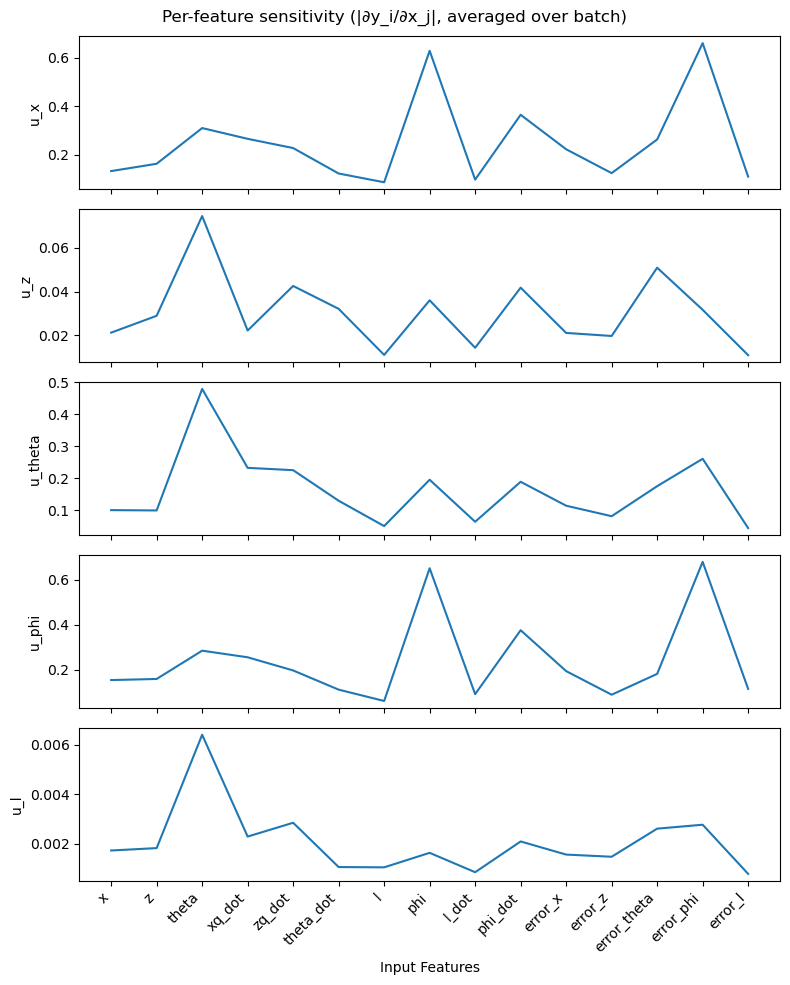

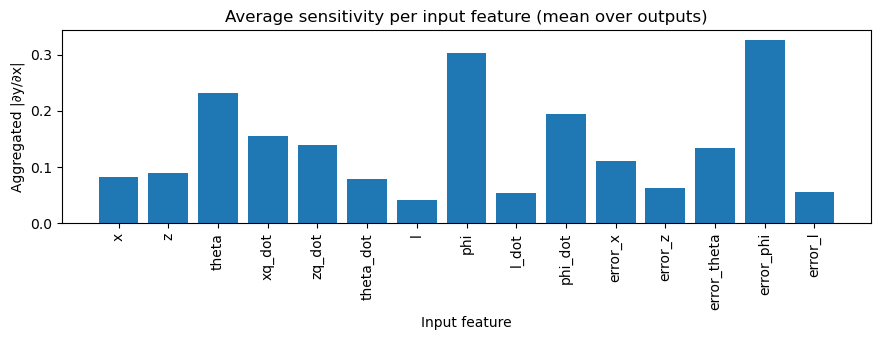

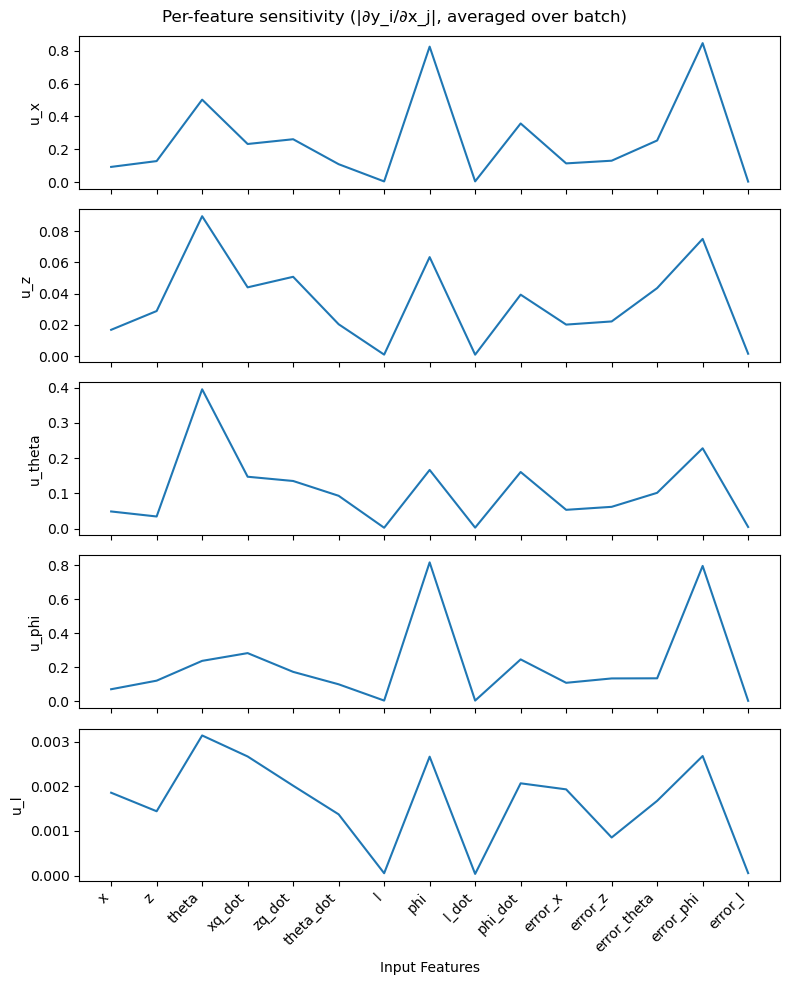

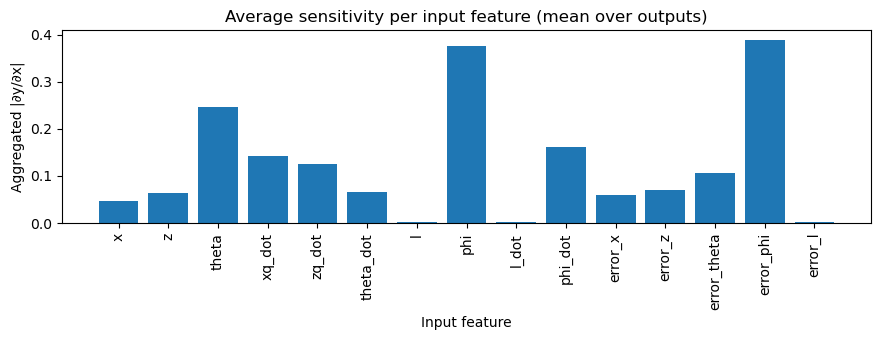

In [14]:
T = cfg_clean["model"]["in_dim"]

S_clean = rb.compute_and_plot_feature_sensitivity(
    model_clean, test_loader, device,
    max_batch_size=32,
    input_names=feature_names,          # or a list of feature names for tabular data
    output_names=[f"u_{axis}" for axis in cps.CONTROL_AXES],         # e.g., ["angle", "velocity"] if 2-D output
    input_shape=(T,),          # e.g., (T,) for sequences to get line plots
    top_k_bar=20,              # show top-20 most sensitive inputs in bar plot
)

S_adv = rb.compute_and_plot_feature_sensitivity(
    model_adv, test_loader, device,
    max_batch_size=32,
    input_names=feature_names,
    output_names=[f"u_{axis}" for axis in cps.CONTROL_AXES],
    input_shape=(T,),
    top_k_bar=20,
)